# Tensorflow 2 implementation of Open-Neural-APC

In [1]:
# extention to run neural-apc in google colab and retrieving all neccessary files
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    !git clone https://github.com/nicojahn/open-neural-apc.git
    !rsync -a open-neural-apc/* ./

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%%bash
# install and update required packages
python3 -m pip install --upgrade pip -q
python3 -m pip install --upgrade -r requirements.txt -q

# just for the video output/investigation (not necessary for training/testing)
python3 -m pip install --upgrade -r optionals.txt -q

# this is also optional, since it is only needed for opencv videos
apt-get -qq update && apt-get -qq install -y libsm6 libxext6 libxrender1 libfontconfig1 libgl1-mesa-glx

In [4]:
from utils import loadConfig, allow_growth
from tqdm import tqdm
# read the config file
# it includes more or less all hyperparameter used in the model and preprocessing/training step
data_parameter, model_parameter, training_parameter = loadConfig()
# Since I saved the data as "uint8" and the sensor is usually placed at a height of 2 meters
#    the resolution should be just below 1cm
#    but since the noise frames at the end of most sequences produce larger values, this might not be the case
# The "accuracy error niveau" is the absolutely permissible difference so that a prediction 
#    on the label is still counted as correct (remember: it's a regression task)
# The "jump input frames" parameter indicates which frames are used from the original sequence
# The original sequences are at about 40 FPS. The model is trained with just 10 FPS
# The "pretrain" parameter is not used so far but could be utilized with a pretraining of the input layer
# The "safe steps" parameter is used to safe the model every "safe steps" epochs

# switching between the gpus
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
#os.environ["CUDA_VISIBLE_DEVICES"] = '0'
# disable annoying tf warnings (retracing etc.)
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
# enable GPU memory growth
allow_growth()
#tf.config.experimental_run_functions_eagerly(True)

{
  "data parameter": {
    "data directory": "./data/",
    "input scaling factor": 255,
    "labels dtype": "uint32",
    "sequence dtype": "uint8"
  },
  "model parameter": {
    "bidirectional": true,
    "input dimensions": [
      20,
      25
    ],
    "lstm depth": 5,
    "lstm width": 64,
    "merge_mode": "sum",
    "output dimensions": 2
  },
  "training parameter": {
    "accuracy error niveau": 0.5,
    "aux scale": 3,
    "batch size": 32,
    "calculation dtype": "float16",
    "calculation epsilon": 1e-07,
    "dropout rate": 0.2,
    "epochs": 5000,
    "jump input frames": 4,
    "learning rate": 0.001,
    "maximum concatenation": 5,
    "minimum concatenation": 5,
    "optimizer clip parameter": [
      1.0,
      2.0
    ],
    "optimizer parameter": [
      0.9,
      0.999,
      1e-07
    ],
    "pretrain": false,
    "restrict dataset size": 1500,
    "safe steps": 5,
    "v1RNN": false
  }
}


In [5]:
# enable effcient data processing
sequence_dtype = data_parameter["sequence dtype"]
labels_dtype = data_parameter["labels dtype"]
calculation_dtype = training_parameter["calculation dtype"]
calculation_epsilon = training_parameter["calculation epsilon"]

# enable single/half/double precision
import tensorflow.keras.backend as K
K.set_floatx(calculation_dtype)
K.set_epsilon(calculation_epsilon)

# enable mixed precission
if 'float16' in calculation_dtype:
    from tensorflow.keras.mixed_precision import experimental as mixed_precision
    #loss_scale = tf.mixed_precision.experimental.DynamicLossScale(initial_loss_scale=(2 ** 15), increment_period=2000, multiplier=2.0)
    policy = mixed_precision.Policy('mixed_float16')#, loss_scale=loss_scale)
    mixed_precision.set_policy(policy)

import numpy as np
# scale saved input into a normed range 
input_scaling_factor = np.asarray(data_parameter["input scaling factor"],dtype=calculation_dtype)

In [6]:
from napc import NeuralAPC

# First step into using multiple GPU's at once
# Needs adaption of batch size and learning rate (for optimal performance)
#strategy = tf.distribute.MirroredStrategy().scope()
#strategy = tf.distribute.experimental.CentralStorageStrategy().scope()
strategy = tf.init_scope() # Use again only 1 GPU
with strategy:
    napc = NeuralAPC(model_parameter,training_parameter)
    napc.compile()
    napc.save()

# copy config into model folder
import shutil
config_path = shutil.copy2('config.json', napc.model_path)
print(f'Config saved under {config_path}')

Config saved under ./models/2020-09-07_18:44:00.610082/config.json


In [7]:
import os
import os.path as path
mode = "training"
data = path.join(data_parameter['data directory'], f'{mode}.dat')
data_lengths = path.join(data_parameter['data directory'], f'{mode}_meta.dat')

# This one solves the problem for all of you, which just click 'Run all' and expect it to work
# Since the training data is not uploaded 'on purpose', the code would usually break for most people
# If the file does not exists, the code immediately jumps to the point, where it loads the 'predefined' model and evaluates it
# Elsewise it trains the model and evalutes the newly trained
data_exists = os.path.isfile(data)

sequence_list = labels_list = None

if data_exists:
    print("Found the training data!")
    from data_loader import readData
    # due to the expertise of github.com/xor2k, I switched from CSV to memory-mapped files.
    # This reduces the loading/mapping time by a lot.
    # The sequence_list is a list containing all sequences for training (The sequences have the shape of Tx20x25)
    # all sequences are differently long and are normalized in the range between 0. and 1., they have the dtype 'sequence_dtype'
    # The labels_list is a list with all the labels for training in the same order as the sequence_list is.
    # The shape of each label is 2 --> Therefore, the list could have the shape Nx2 as array. The labels have dtype 'labels_dtype'
    sequence_list, labels_list = readData(model_parameter,training_parameter,data,data_lengths,sequence_dtype,labels_dtype)
    # Similar to my bachelors thesis I used just about 1500 sequences (Not necessarily the same ones/ haven't checked it)
    # Not necessary for other people or experiments
    # sequence_list, labels_list = sequence_list[:training_parameter["restrict dataset size"]], labels_list[:training_parameter["restrict dataset size"]]
else:
    print("Oh nooo...Haven't found the training data. Therefore, no training possible.")

Found the training data!
Started reading files: 18:44:03 2020-09-07
Finished reading 1499 sequences. Took 1.600000 seconds.


In [8]:
from data_generator import DataGenerator
generator = None
if data_exists:
    # this is class which preprocesses the training data every epoch
    # it creates the necessary labels/bounds and augments the data
    generator = DataGenerator(sequence_list,labels_list,input_scaling_factor,training_parameter,calculation_dtype)

Epoch 1/5000
10/10 [==============================] - ETA: 0s - loss: 1.6130 - accuracy: 0.1043

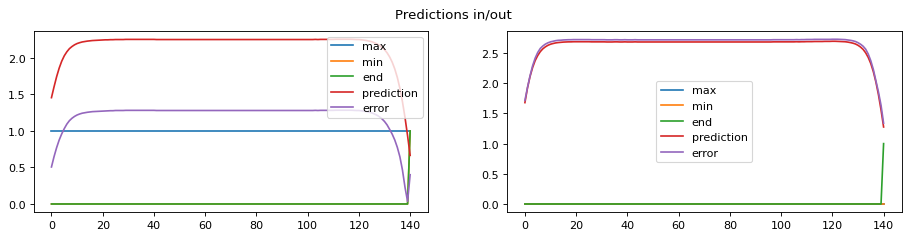

10/10 [==============================] - 10s 1s/step - loss: 1.6130 - accuracy: 0.1043
Epoch 2/5000
10/10 [==============================] - 6s 602ms/step - loss: 1.6218 - accuracy: 0.0919
Epoch 3/5000
10/10 [==============================] - 6s 565ms/step - loss: 1.5853 - accuracy: 0.1051
Epoch 4/5000
10/10 [==============================] - 6s 627ms/step - loss: 1.5816 - accuracy: 0.1177
Epoch 5/5000
10/10 [==============================] - 6s 577ms/step - loss: 1.5625 - accuracy: 0.1170
Epoch 6/5000
 4/10 [===========>..................] - ETA: 2s - loss: 1.6129 - accuracy: 0.1187

KeyboardInterrupt: 

In [9]:
from optional_features import customPlot
# train
if data_exists:
    
    callbacks = []
    callbacks += [napc.IncreaseEpochCustom(napc)]
    callbacks += [napc.SaveEveryNthEpochCustom(napc,training_parameter['safe steps'])]
    # tensorboard callback
    callbacks += [tf.keras.callbacks.TensorBoard(log_dir=napc.model_path+'/logs', histogram_freq=0, write_graph=True, \
                                                 write_images=False, update_freq='epoch', profile_batch=0, \
                                                 embeddings_freq=0, embeddings_metadata=None)]
    # custom callback for creating the plots
    '''
    try: 
        callbacks += [customPlot(generator,napc,plot_freq=1000)]
    except ValueError:
        pass
    '''
    
    generator.on_epoch_end()
    napc.model.fit(generator,epochs=training_parameter['epochs'],initial_epoch=napc.epoch,\
                   max_queue_size=generator.num_batches, workers=4, use_multiprocessing=False, callbacks=callbacks)

    # the training took about 12-16 hours on a 2080TI while occupying less than 3GB VRAM and 80% GPU-Util.
    # always depending on the LSTM implementation (CPU/GPU/CUDNN_TF1/CUDNN_TF2), the precision and data preparation
    # got my fastest time per epoch training performance with 16bit(half->mixed) precision, CUDNN v1 implementation (without Dropout),
    #   batchsize divisible by 16 (larger is not always better) and lstm layer width divisible by 32

In [10]:
# For all of you which don't have the training data and just want to execute it
if not data_exists:
    data_parameter, model_parameter, training_parameter = loadConfig('models/config.json',verbose=False)
    napc = NeuralAPC(model_parameter,training_parameter)
    # Loading the included model (it has no subdirectory)
    napc.loadModel(10000,'models/')
    # The model_path of the model is not 'models/', but the previously created subdirectory
    # You could now train it further/save it/ etc.

In [12]:
# produce videos on all validation sequences
import os.path as path
mode = "validation"
data = path.join(data_parameter['data directory'], f'{mode}.dat')
data_lengths = path.join(data_parameter['data directory'], f'{mode}_meta.dat')

# de-/activate video creation
create_vids = False

# copy dict from training and modify the concatenation and batch size
validation_parameter = training_parameter.copy()
validation_parameter["minimum concatenation"] = 1
validation_parameter["maximum concatenation"] = 1

# read the validation data
from data_loader import readData
validation_sequence_list, validation_labels_list = readData(model_parameter,validation_parameter,data,data_lengths,sequence_dtype,labels_dtype)

# process them (i need the bounds in y for the accuracy and the videos)
from data_generator import DataGenerator
validation_generator = DataGenerator(validation_sequence_list,validation_labels_list,input_scaling_factor,validation_parameter,calculation_dtype)
# With training=False, no augmentation is applied to the input data
# Therefore, results are the closest possible real-world setting
validation_generator.on_epoch_end(training=False)

# creates my videos
from optional_features import createVideo
accuracy = []
for batch_idx in range(validation_generator.num_batches):
    x,y = validation_generator[batch_idx]
    predictions = napc.model.predict_on_batch(x)
    if create_vids:
        for sample_idx, prediction in enumerate(predictions):
            output_dimensions = model_parameter['output dimensions']
            binary_mask = (np.minimum(0,y[sample_idx,:,2*output_dimensions])+1).astype(bool)
            createVideo(napc.epoch,sample_idx,x[sample_idx,binary_mask], \
                                        K.eval(prediction[binary_mask]), \
                                        y[sample_idx,binary_mask,0:output_dimensions], \
                                        y[sample_idx,binary_mask,output_dimensions:2*output_dimensions])
    accuracy += [K.eval(napc.accuracy(y,predictions))]

Started reading files: 18:45:44 2020-09-07
Finished reading 15 sequences. Took 0.000000 seconds.


In [13]:
# Since I'm not allowed to upload more sequences and I don't want to publish a perfect model
# (therefore, I haven't tested this one) the accuracy is just an approximation of the true capabilities
# The 'validation' data in this case is in fact a test set (last epoch was chosen without selection)
# In practice someone would use k-Fold-Crossvalidation and would reason about the average performance

# So let's have a look how well the model does...
print(f'{mode} accuracy: {100*np.mean(accuracy)} %')

validation accuracy: 3.33251953125 %


In [14]:
if 'float16' in calculation_dtype:
    # Check again if we've run our model with mixed precision
    print('Compute dtype: %s' % policy.compute_dtype)
    print('Variable dtype: %s' % policy.variable_dtype)
    # Print the final loss scale
    loss_scale = policy.loss_scale
    print('Loss scale: %s' % loss_scale)

Compute dtype: float16
Variable dtype: float32
Loss scale: DynamicLossScale(current_loss_scale=32768.0, num_good_steps=55, initial_loss_scale=32768.0, increment_period=2000, multiplier=2.0)
